# Data preparation
Before running code, delete samples after STAFF 500 from both files, they have no assay data. Also rename Rainer's columns (bsa, n, s, rbd, lps, sero). Create a notes column in the demographic and symptom data and put extra info in the id column in there. Then save as `.csv`s

- Merge Papworth staff demographic data with Rainer's lab data.
- Clean badly labeled data.
- Explore sample numbers.
- Plot some relationships between interesting variables. Some of these should be between assays within sero positive cases.

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.decomposition import PCA
from sklearn import preprocessing

%load_ext rpy2.ipython
from rpy2.robjects import r

In [3]:
%%R
packages <- c("ggplot2", "dplyr", "diosR", "plot.matrix")
lapply(packages, require, character.only=T)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] FALSE

[[4]]
[1] TRUE



In [4]:
os.chdir("/home/david/linux_work/coronavirus_2020/papworth/staff_analysis/data")

# Merge dataframe

In [5]:
#DEMOgraphic data
demo = pd.read_csv("rawdata/papworth_staff_demographic.csv")
#LUMInex data from Rainer
lumi = pd.read_csv("rawdata/rainer_papworth_staff_200617.csv")

demo = demo.rename(columns={"ID":'id',
                            'laminar flow result 1=neg; 2=pos': 'laminar',
                            'COVID severity 1=asymp; 2=mild; 3=moderate (inc any signs pneumonia15/06/2020 fevere, cough, dyspnoea but not desturation); 4=severe: desaturation': 'severity',
                            'ethicity 1=white; 2=mixed, 3=asian, 4=black, 5 =other':'ethnicity',
                            'Job classification : 1 = clinical; 2 = admin': 'jobtype',
                            'work location: 1=patient facing critical care; 2= patient facing non-critical care; 3 = nonpatient facing': 'location'
                           })
demo.columns

Index(['id', 'laminar', 'age', 'sex', 'severity', 'ethnicity', 'jobtype',
       'location', 'note'],
      dtype='object')

In [6]:
lumi.columns

Index(['id', 'BOOKED ON EPIC', 'DATE TESTED', 'BATCH', 'RESULTED ON EPIC',
       'bsa', 'n', 's', 'rbd', 'lps', 'sero', 'Comment', 'checked'],
      dtype='object')

In [35]:
# In order to merge the data they must have matching IDs
# therefore set all to lower case
demo.id = demo.id.str.lower()
lumi.id = lumi.id.str.lower()

#White space is always causing trouble, remove it
demo.id = demo.id.str.replace(" ", "")
lumi.id = lumi.id.str.replace(" ", "")

#demo has some colon's in the id's
demo.id = demo.id.str.replace(":", "")

#Some odd names in the lumi data
lumi.id = lumi.id.replace("55proj2480-staff", "staff55")
lumi.id = lumi.id.replace("90proj2480-staff", "staff90")
lumi.id = lumi.id.replace("169proj2480-staff", "staff169")
lumi.id = lumi.id.replace("385proj2480-staff", "staff385")
lumi.id = lumi.id.replace("416proj2480-staff", "staff416")
lumi.id = lumi.id.replace("430proj2480-staff", "staff430")

The two sets of samples below are not in both sets of data and so will be lost when we do an inner merge.

In [36]:
demo[~demo.id.isin(lumi.id)]

,id,laminar,age,sex,severity,ethnicity,jobtype,location,note
0,negativecontrol1,NaN,NaN,m,1,1.0,NaN,3.0,NaN
1,staffpositivecontrol1assignstaff8),1.0,40.0,f,3,3.0,1.0,3.0,NaN


In [37]:
lumi[~lumi.id.isin(demo.id)]

,id,BOOKED ON EPIC,DATE TESTED,BATCH,RESULTED ON EPIC,bsa,n,s,rbd,lps,sero,Comment,checked
0,130520_1proj2480,Y,18/05/2020,ICOV15,NaN,145.0,31683.5,31240.5,26494.5,11768.8,P?,?,NaN
442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
lumi.shape

(505, 13)

In [39]:
demo.shape

(502, 9)

In [40]:
staf = pd.merge(demo, lumi, how='inner', on='id')
staf.shape

(500, 21)

# Clean variables

In [41]:
# Clean up some inconsistent variables
#Sex is lower case
staf.sex = staf.sex.str.lower()

In [42]:
#Create a column nep
#indicating seropositive assignment as Negative, Equivocal (anything but N or P), and Positive
staf['nep'] = "E"
staf.nep[staf.sero == "N"] = "N"
staf.nep[staf.sero == "P"] = "P"
staf.nep[staf.sero.isna()] = np.nan

/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [43]:
#set ambiguous severity cases as missing data
staf.severity[~staf.severity.isin(['1','2','3','4'])] = np.nan

/home/david/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
#Check that these variables don't have any ambiguous answers
staf.ethnicity.unique()
staf.jobtype.unique()
staf.location.unique()
staf.laminar.unique()

array([nan,  2.,  1.])

# Sample numbers

In [45]:
pd.crosstab(staf.nep, staf.sex, normalize=False, margins=True)

sex,f,m,All
nep,,,
E,26,9,35
N,253,114,367
P,43,18,61
All,322,141,463


In [46]:
pd.crosstab(staf.nep, staf.severity, margins=True)

severity,1,2,3,4,All
nep,,,,,
E,18,14,3,0,35
N,235,136,14,0,385
P,17,37,10,1,65
All,270,187,27,1,485


In [47]:
pd.crosstab(staf.nep, staf.ethnicity)

ethnicity,1.0,2.0,3.0,4.0,5.0
nep,,,,,
E,27,0,8,1,0
N,308,11,54,7,1
P,46,4,12,2,0


In [48]:
pd.crosstab(staf.nep, staf.jobtype, normalize='columns').round(2)

jobtype,1.0,2.0
nep,,
E,0.08,0.09
N,0.80,0.69
P,0.12,0.22


In [49]:
pd.crosstab(staf.nep, staf.location, normalize='columns').round(2)

location,1.0,2.0,3.0
nep,,,
E,0.07,0.08,0.08
N,0.85,0.79,0.68
P,0.07,0.13,0.24


In [50]:
pd.crosstab(staf.jobtype, staf.location, margins=True)

location,1.0,2.0,3.0,All
jobtype,,,,
1.0,124,279,8,411
2.0,2,4,55,61
All,126,283,63,472


In [51]:
pd.crosstab(staf.nep, staf.laminar)

laminar,1.0,2.0
nep,,
E,6,0
N,20,0
P,0,10


# Explorative plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12c8387250>]],
      dtype=object)

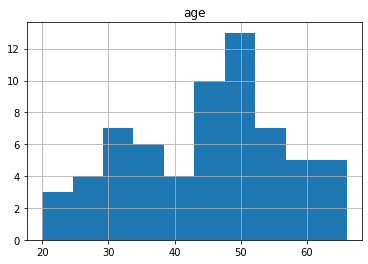

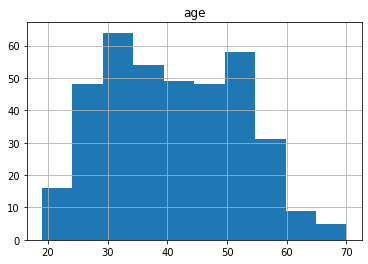

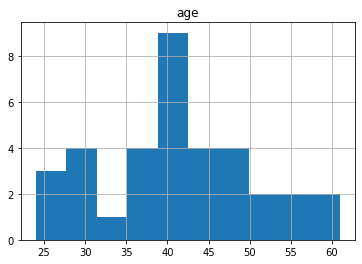

In [52]:
staf[staf.nep=="P"].hist('age')
staf[staf.nep=="N"].hist('age')
staf[staf.nep=="E"].hist('age')

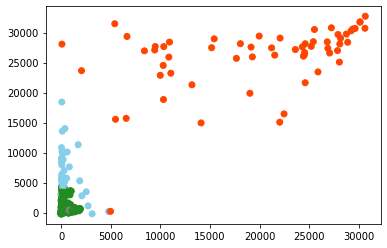

In [53]:
#colour dictionary
colours = {'E':'skyblue', 'P':'orangered', 'N':'forestgreen'}

col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

plt.scatter(staf.s, staf.n, c=col_convert(staf.nep))

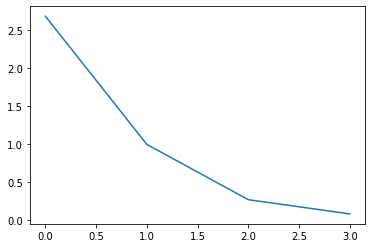

In [54]:
# Can PCA of all luminex assays better spread these out?
staf_lumi = staf[['bsa','n','s','rbd','nep']]
staf_lumi = staf_lumi.dropna()

# center and scale
scaler = preprocessing.StandardScaler()
#Scaled data
scd = scaler.fit_transform(staf_lumi[['bsa','n','s','rbd']])

#Plot indicates that a single component captures most of the variance in the data
pca_base = PCA()
pca_base.fit(scd)

plt.plot(pca_base.explained_variance_)

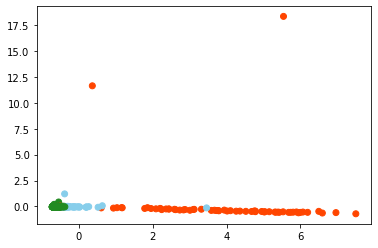

In [55]:
components = pd.DataFrame(pca_base.transform(scd), columns=['pca1','pca2','pca3','pca4'])

#colour dictionary
colours = {'E':'skyblue', 'P':'orangered', 'N':'forestgreen'}

col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

plt.scatter(components.pca1, components.pca2, c=col_convert(staf_lumi.nep))

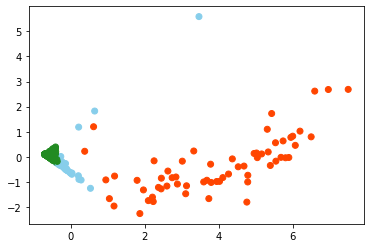

In [56]:
components = pd.DataFrame(pca_base.transform(scd), columns=['pca1','pca2','pca3','pca4'])

#colour dictionary
colours = {'E':'skyblue', 'P':'orangered', 'N':'forestgreen'}

col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

plt.scatter(components.pca1, components.pca3, c=col_convert(staf_lumi.nep))

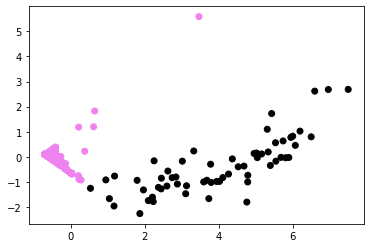

In [57]:
#using a custom n cutoff

components = pd.DataFrame(pca_base.transform(scd), columns=['pca1','pca2','pca3','pca4'])

#colour dictionary
colours = {True:'black', False:'violet'}

col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

plt.scatter(components.pca1, components.pca3, c=col_convert(staf_lumi.n > 14900))

In [58]:
staf_lumi.n > 15000

1      False
2      False
3       True
4       True
5      False
       ...  
493    False
494    False
497    False
498    False
499    False
Name: n, Length: 490, dtype: bool

There are two very strange samples making the second pca components very uninformative. Whic two staff are these and what makes them weird, if we ignore them is it more informative?

In [32]:
# staf.to_csv("staff_demographic_antibodies.csv", index=False)

# Symptoms
There is a new dataset to include which has the symptom breakdown. Add symptoms data

In [119]:
symp = pd.read_csv("rawdata/papworth_staff_demographic_symptoms.csv")
symp = symp.rename(columns={
    'ID':'id',
    'BLOOD SPOT 1=positive 2=negative': 'bloodspot',
    'swab at time of symptoms 1=pos 2=neg': 'swabtime',
    'anosmia': "anosmia",
    'fatigue 1= yes. 2=no': "fatigue",
    'myalgia 1= yes. 2=no': "myalgia",
    'GI 1= yes. 2=no': "gi",
    'pharyngitis 1= yes. 2=no': "pharyngitis",
    'cough 1= yes. 2=no': "cough",
    'dyspnoea 1= yes. 2=no': "dyspnoea",
    'fever 1= yes. 2=no': "fever",
    'headache 1= yes. 2=no': "headache",
    'URTI 1= yes. 2=no': "utri",
    'other': "other",
    'COVID severity 1=asymp; 2=mild; 3=moderate (inc any signs pneumonia15/06/2020 fevere, cough, dyspnoea but not desturation); 4=severe: desaturation': "severity",
    'duration 1=<1 week; 2=>1 week': "duration",
    'month (calendar (note 12- = 2019 month)': "month"
})

In [120]:
# In order to merge the data they must have matching IDs
# therefore set all to lower case
symp.id = symp.id.str.lower()

#White space is always causing trouble, remove it
symp.id = symp.id.str.replace(" ", "")

In [121]:
# set month to 0 for december 2019
symp.loc[symp.month.isin(['12', '12-']),'month'] = 0

In [122]:
symp[~symp.id.isin(staf.id)]

,id,bloodspot,swabtime,anosmia,fatigue,myalgia,gi,pharyngitis,cough,dyspnoea,fever,headache,utri,other,severity,duration,month,note
0,negativecontrol1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,staff:positivecontrol1:assignstaff8),2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,3,NaN,4,NaN
403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
502,staff501,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
503,staff502,1.0,NaN,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,2,1.0,NaN,NaN
504,staff503,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
505,staff504,NaN,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,NaN,2,1.0,NaN,NaN
506,staff505,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
507,staff506,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
508,staff507,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


In [123]:
stafsymp = pd.merge(staf, symp, how="left", on="id", suffixes = ("","_symp"))

### Clean symptom values

In [124]:
stafsymp.bloodspot.unique()
stafsymp.swabtime.unique()
stafsymp.anosmia.unique()
stafsymp.fatigue.unique()
stafsymp.myalgia.unique()
stafsymp.gi.unique()
stafsymp.pharyngitis.unique()
stafsymp.cough.unique()
stafsymp.dyspnoea.unique()
stafsymp.fever.unique()
stafsymp.headache.unique()
stafsymp.utri.unique()
stafsymp.other.unique()
stafsymp.month.unique()

array(['2', nan, '4', '3', 0, '1', '5'], dtype=object)

In [125]:
# stafsymp.to_csv("staff_demographic_symptoms_antibodies.csv", index=False)